In [1]:
import pandas as pd 
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn import linear_model 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.describe()
# we can see that 38% out of the training set survived the Titanic 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# We want to check the correlation between the features and survival rate (quantitative features)

corr = train_df.corr()
corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


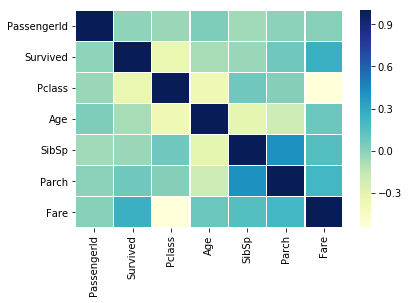

In [5]:
# create the heatmap to visualize correlations 
sns.heatmap(corr, linewidths = .5, cmap="YlGnBu")

# we can see that Pclass, Fare are two that are highly correlated with survival 
# next would be Parch, Age, SibSp, and finally PassengerId 

In [6]:
#check to see which columns contain NaN values 
train_df.isna().any()

# Since Age is an important factor, we want to fill in all of the missing ages with the average 

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [7]:
# a more detailed look at what data is actually missing for the three features 

missing = train_df.isnull().sum().sort_values(ascending=False)
percent = train_df.isnull().sum()/train_df.isnull().count().sort_values(ascending=False)*100
missing_data = pd.concat([missing, percent], axis=1, keys=['Total', 'Percentage'], sort=True)
missing_data.head(4)

,Total,Percentage
Age,177,19.865320
Cabin,687,77.104377
Embarked,2,0.224467
Fare,0,0.000000


In [8]:
# fill the missing ages with the average from each dataset 

avg_age_train = train_df['Age'].mean()
avg_age_test = test_df['Age'].mean()

train_df['Age'] = train_df['Age'].fillna(avg_age_train)
test_df['Age'] = test_df['Age'].fillna(avg_age_test)

test_df['Age'].describe()
#train_df['Age'].describe()

count    418.000000
mean      30.272590
std       12.634534
min        0.170000
25%       23.000000
50%       30.272590
75%       35.750000
max       76.000000
Name: Age, dtype: float64

In [9]:
# The prefix of the cabin of the cabin defines the deck level. Goal is to extract this and then create a new 
# feature that contains a person's deck. Fill unknown w/ 0 as deck 

import re

deck = {'A': 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data: 
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    # looks for any a-z preceding the + 
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [10]:
# fill the embarked w/ most frequent value since it only has two missing values 
train_df['Embarked'].describe()


count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [11]:
most_common = 'S'
data = [train_df, test_df]

for dataset in data: 
    dataset['Embarked']= dataset['Embarked'].fillna(most_common)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
Deck           891 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 83.6+ KB


In [13]:
# We want to convert fare into an integer 
data = [train_df, test_df]

for dataset in data: 
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)


In [14]:
# convert sex to numeric
sex = {'female': 1, 'male': 0}
data = [train_df, test_df]

for dataset in data: 
    dataset['Sex'] = dataset['Sex'].map(sex)

In [15]:
# ticket feature
train_df['Ticket'].describe() 

# we will drop the ticket value since it doesn't seem to be correlated w/ survival and it's hard to 
# convert this into a meaningful value 


count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [16]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis = 1)

In [17]:
ports = {'S':0, 'C':1, 'Q':2}
data = [train_df, test_df]

for dataset in data: 
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [18]:
train_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,31.785634,0.361392,6.936027
std,257.353842,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.703730,0.635673,2.074282
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.000000,0.000000,8.000000
50%,446.000000,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.000000,0.000000,8.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000,8.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.000000,2.000000,8.000000


In [19]:
# extract titles in the name and make it into a categorical features

data = [ train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}

for dataset in data: 
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)
    # replace the weird titles w/ other
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(5)

train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1) 

train_df.head(5)
    

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,1,0,3,0,22.0,1,0,7,0,8,1
1,2,1,1,1,38.0,1,0,71,1,3,3
2,3,1,3,1,26.0,0,0,7,0,8,2
3,4,1,1,1,35.0,1,0,53,0,3,3
4,5,0,3,0,35.0,0,0,8,0,8,1


In [20]:
# convert age into categories 
data = [train_df, test_df]
for dataset in data: 
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <=18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <=25), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <=32), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <=40), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <=60), 'Age'] = 5
    dataset.loc[ dataset['Age'] > 60, 'Age'] = 6
    
train_df['Age'].value_counts()    


3    324
2    162
5    126
4    118
1     71
0     68
6     22
Name: Age, dtype: int64

In [21]:
x_train = train_df.drop(["Survived", "PassengerId"], axis=1)
y_train = train_df["Survived"]
x_test  = test_df.drop("PassengerId", axis=1).copy()

print(x_train.shape)

(891, 9)


In [22]:
## Logistic Regression 

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

#Returns the mean accuracy on the given data and labels.
acc_log = round(logreg.score(x_train,y_train)* 100, 2)
acc_log

81.709999999999994

In [23]:
## KNN nearest neighbors
knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
acc_knn = round(knn.score(x_train,y_train) * 100, 2)
acc_knn

86.310000000000002

In [24]:
# output KNN predictions to csv 
preds = pd.DataFrame(y_pred, columns=['Survived'])
#print(preds.head(5))

#np.savetxt("preds.csv",y_pred, delimiter=",")
predictions = pd.concat([test_df['PassengerId'], preds], axis=1)
predictions.head(5)

predictions.to_csv("preds_knn.csv", index=False)

In [25]:
## Random Forest 

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
acc_rf = round(rf.score(x_train, y_train)* 100, 2)
acc_rf

93.599999999999994

In [26]:
# output random forest predictions to csv 
preds = pd.DataFrame(y_pred, columns=['Survived'])
#print(preds.head(5))

#np.savetxt("preds.csv",y_pred, delimiter=",")
predictions = pd.concat([test_df['PassengerId'], preds], axis=1)
predictions.head(5)

predictions.to_csv("predictions.csv", index=False)

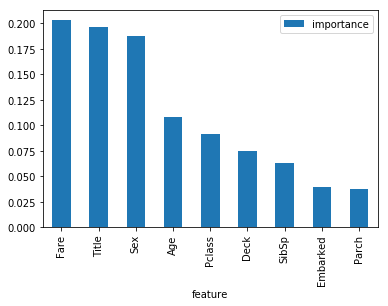

In [27]:
importances = pd.DataFrame({'feature':x_train.columns, 
                            'importance': np.round(rf.feature_importances_,3)})
importances.sort_values('importance', ascending=False).set_index('feature').plot.bar()

# it seems like parch and embarked don't really have a significant role 
# in the rf process so we'll remove it and retrain 

In [28]:
train_df = train_df.drop(['Parch', 'Embarked', 'Survived', 
                         'PassengerId'], axis=1)
test_df = test_df.drop(['Parch', 'Embarked', 'PassengerId'], axis=1)

In [29]:
list(train_df)

['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Deck', 'Title']

In [30]:
list(test_df)

['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Deck', 'Title']

In [31]:
# Retrain random forest after removing Parch and Embarked  
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(x_train, y_train)
y_preds = rf.predict(x_train)

rf.score(x_train, y_train)

acc_rf = round((rf.score(x_train, y_train))* 100, 2)
print(acc_rf)

93.6
